<a href="https://colab.research.google.com/github/KangGao1997/Donkey_car/blob/main/Training_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Mon Apr 24 20:39:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    46W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!unzip widedata.zip

# Load the data

In [ ]:
import numpy as np
import glob, os

In [ ]:
img_name = []
angle = []
throttle = []

In [ ]:
for file in glob.glob("/content/widedata/*.catalog"):
    with open(file) as f:
        for line in f:
            img_name.append(line.split()[7][1:-2])
            angle.append(float(line.split()[9][0:-1]))
            throttle.append(float(line.split()[13][0:-1]))

len(img_name)

8739

In [ ]:
import cv2
image = []
for i in range(len(img_name)):
    img = cv2.imread(os.path.join("/content/widedata/images",img_name[i]))
    image.append(img)
    """
        if img is not None:
            images.append(img)
    """
    
image = np.array(image)
image.shape

(8739, 224, 224, 3)

In [ ]:
import cv2
image = []
for i in range(len(img_name)):
    img = cv2.imread(os.path.join("/content/segda",img_name[i]))
    image.append(img)
    """
        if img is not None:
            images.append(img)
    """
    
image = np.array(image)
image.shape

In [ ]:
#check the imported images
import cv2
from google.colab.patches import cv2_imshow
#cv2_imshow(image[1])
image[1].shape

(224, 224, 3)

# Define the model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, BatchNormalization, SpatialDropout2D
from tensorflow.keras.layers import Activation, Dropout, Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import TimeDistributed as TD
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2DTranspose
from tensorflow.keras.backend import concatenate
from tensorflow.keras.models import Model
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
def conv2d(filters, kernel, strides, layer_num, activation='relu'):
    """
    Helper function to create a standard valid-padded convolutional layer
    with square kernel and strides and unified naming convention

    :param filters:     channel dimension of the layer
    :param kernel:      creates (kernel, kernel) kernel matrix dimension
    :param strides:     creates (strides, strides) stride
    :param layer_num:   used in labelling the layer
    :param activation:  activation, defaults to relu
    :return:            tf.keras Convolution2D layer
    """
    return Convolution2D(filters=filters,
                         kernel_size=(kernel, kernel),
                         strides=(strides, strides),
                         activation=activation,
                         name='conv2d_' + str(layer_num))

In [ ]:
def core_cnn_layers(img_in, drop, l4_stride=1):
    """
    Returns the core CNN layers that are shared among the different models,
    like linear, imu, behavioural

    :param img_in:          input layer of network
    :param drop:            dropout rate
    :param l4_stride:       4-th layer stride, default 1
    :return:                stack of CNN layers
    """
    x = img_in
    x = conv2d(24, 5, 2, 1)(x)
    x = SpatialDropout2D(drop)(x)
    x = conv2d(32, 5, 2, 2)(x)
    x = SpatialDropout2D(drop)(x)
    x = conv2d(64, 5, 2, 3)(x)
    x = SpatialDropout2D(drop)(x)
    x = conv2d(64, 3, l4_stride, 4)(x)
    x = SpatialDropout2D(drop)(x)
    x = conv2d(64, 3, 1, 5)(x)
    x = SpatialDropout2D(drop)(x)
    x = Flatten(name='flattened')(x)
    return x

In [ ]:
def default_n_linear(num_outputs, input_shape=(120, 160, 3)):
    drop = 0.2
    img_in = Input(shape=input_shape, name='img_in')
    x = core_cnn_layers(img_in, drop)
    x = Dense(100, activation='tanh', name='dense_1')(x)
    x = Dropout(drop)(x)
    x = Dense(50, activation='tanh', name='dense_2')(x)
    x = Dropout(drop)(x)

    outputs = Dense(2, activation = 'sigmoid', name = 'outputs')(x)

    model = Model(inputs=[img_in], outputs=outputs, name='linear')
    return model

In [ ]:
model = default_n_linear(2, input_shape = (224,224,3))

# Data preprocessing

In [ ]:
throttle = np.array(throttle)
steering = np.array(angle)
throttle.shape

(8739,)

In [ ]:
train_img = (image)
train_img.shape

(8739, 224, 224, 3)

In [ ]:
label = steering #np.vstack([throttle,angle]).transpose()
label = label + 1
label.shape, np.unique(label, return_counts=True)

((8739,), (array([0., 1.]), array([3847, 4892])))

In [ ]:
# clean the data if needed, in current track, the throttle(label) should only contain 0/1 (-1/0 + 1)

label = label[np.where(label != 2)[0]]
train_img = train_img[np.where(label != 2)[0]]
train_img.shape, label.shape

((8739, 224, 224, 3), (8739,))

In [ ]:
# transfer to categorical label
from keras.utils import to_categorical
label = to_categorical(label)
label.shape, np.unique(label, return_counts=True)

((8739, 2), (array([0., 1.], dtype=float32), array([8739, 8739])))

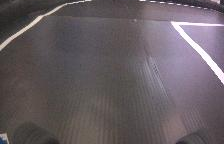

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
cv2_imshow(train_img[0][80:224])

In [ ]:
train_img = np.mean(train_img,axis = 3)
train_img_cut = train_img[:,80:224,:]
train_img_cut.shape,train_img.shape

(8739, 224, 224)

In [ ]:
seg_thres = np.mean(train_img) + 2*np.std(train_img)
seg_thres

203.60605147368386

In [ ]:
for i in range(train_img.shape[0]):
  train_img_cut[i][np.where(train_img_cut[i] > seg_thres) ] = 255
  train_img_cut[i][np.where(train_img_cut[i] <= seg_thres)] = 0
  cv2.imwrite('/content/seg_data/' + str(i) + '.jpg', train_img_cut[i])

In [ ]:
#train_img[87][np.where(train_img[87] > seg_thres) ] = 255
#train_img[87][np.where(train_img[87] <= seg_thres)] = 0

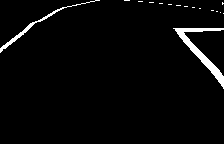

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
cv2_imshow(train_img[100][80:224])
#np.where(train_img[95][80:224] == 255)


In [ ]:
np.unique(train_img[87])

array([  0, 255], dtype=uint8)

In [ ]:
print(train_img[87])

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0 255]]

 [[  0   0   0]
  [  0   0   0]
  [255 255 255]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0 255]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0 255]
  [  0   0 255]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]


# Traning

In [ ]:
optimizer = tf.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999)

In [ ]:
model.compile(optimizer = optimizer, loss = keras.losses.CategoricalCrossentropy(), metrics = [keras.losses.CategoricalCrossentropy()])

In [ ]:
trained_model = model.fit(train_img, label, epochs = 500, batch_size = 100) #too larege???

In [ ]:
model.save("mse_10000img.h5")